# Step 1: Setup env, SQL connection and analyze SQL database data

Import necessary libraries when needed and establish connection to SQL database (noshow.db)

In [3]:
# Import libraries that are currently needed
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set path to SQL database
db_path = "../data/noshow.db"

# Create connection to SQL database
conn = sqlite3.connect(db_path)

# Set pandas options for better readbility
pd.set_option('display.max_columns', None) # Display all columns in DataFrame
pd.set_option('display.max_rows', 100) # Limit number of rows displayed

# Setup matplotlib and seaborn for inline visualization
%matplotlib inline
sns.set(style = "whitegrid")

Explore database structure by listing all available tables before further actions

In [4]:
# Query to list all tables in database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Display list of tables
tables

,name
0,noshow


Since there is only 'noshow' table in the database, the first few rows can be previewed to understand its structure

In [5]:
# Preview first few rows of 'noshow' table
noshow_query = "SELECT * FROM noshow LIMIT 10;"
df_noshow = pd.read_sql(noshow_query, conn)

# Display first 10 rows of table
df_noshow.head()

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0


The structure of 'noshow' table consists of following columns:
- booking_id (Unique value)
- no_show
- branch
- booking_month
- arrival_month
- arrival_day
- checkout_month
- checkout_day
- country
- first_time
- room (Drop missing values)
- price (Drop missing values)
- platform
- num_adults
- num_children

The schema of 'noshow' table is retrieved to understand the columns and their data types

In [6]:
# Get schema of 'noshow' table
schema_query = "PRAGMA table_info(noshow);"
schema_df = pd.read_sql(schema_query, conn)

# Display schema information
schema_df

,cid,name,type,notnull,dflt_value,pk
0,0,booking_id,INTEGER,0,None,0
1,1,no_show,REAL,0,None,0
2,2,branch,TEXT,0,None,0
3,3,booking_month,TEXT,0,None,0
4,4,arrival_month,TEXT,0,None,0
5,5,arrival_day,REAL,0,None,0
6,6,checkout_month,TEXT,0,None,0
7,7,checkout_day,REAL,0,None,0
8,8,country,TEXT,0,None,0
9,9,first_time,TEXT,0,None,0


From the schema, some columns can be seen to have TEXT type data so they will have to be converted to REAL type using one-hot encoding

# Step 2: Perform Exploratory Data Analysis (EDA) on 'noshow' table

Load all the data into a DataFrame to start data analysis

In [7]:
# Get all data from 'noshow' table
noshow_data_query = "SELECT * FROM noshow;"
noshow_data_df = pd.read_sql_query(noshow_data_query, conn)

Use booking_id to eliminate duplicate data as each row should be unique

In [8]:
noshow_data_df = noshow_data_df.drop_duplicates(subset = "booking_id", keep = "first")
noshow_data_df

,booking_id,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,price,platform,num_adults,num_children
0,94113,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,SGD$ 492.98,Website,1,0.0
1,86543,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,SGD$ 1351.22,Website,2,0.0
2,75928,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,None,Agent,1,0.0
3,66947,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,SGD$ 666.04,Website,1,0.0
4,106390,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,USD$ 665.37,Website,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,4823,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,USD$ 612.18,Website,1,1.0
119387,25062,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,USD$ 1041.29,Email,2,0.0
119388,81936,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,USD$ 641.47,Email,1,2.0
119389,6738,0.0,Changi,February,February,25.0,February,27.0,China,Yes,None,SGD$ 886.35,Website,2,0.0


Drop booking_id column after removing duplicates as each row is now unique

In [9]:
drop_col_noshow_data_df = noshow_data_df.drop(columns = "booking_id")

Clean-up rows with missing cell info <br>
Example: If cell in row has missing value, then row should be dropped

Firstly, check which columns have missing data

In [10]:
# Check number of rows that have missing data
missing_data = drop_col_noshow_data_df.isnull().sum()

# Display number of affected rows
print("Missing values in each column: ")
print(missing_data[missing_data > 0])

Missing values in each column: 
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64


~~Next, drop all rows that have missing values~~ <br>
Use median/mode to replace missing values <br>
Only drop row if all values are missing

In [11]:
# Drop rows if there are any missing values
#cleaned_noshow_data_df = drop_col_noshow_data_df.dropna()

# Drop rows if all cells in that row have missing values
cleaned_noshow_data_df = drop_col_noshow_data_df.dropna(how="all")

# Use median/mode to replace missing values
cleaned_noshow_data_df["room"] = cleaned_noshow_data_df["room"].fillna("Unknown")

# Verify if all missing values are dropped
print("Missing values after dropping rows: ")
print(cleaned_noshow_data_df.isnull().sum())

Missing values after dropping rows: 
no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room                  0
price             24881
platform              0
num_adults            0
num_children          0
dtype: int64


C:\Users\victo\AppData\Local\Temp\ipykernel_38848\2909875049.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_noshow_data_df["room"] = cleaned_noshow_data_df["room"].fillna("Unknown")


Do manual data conversion for price and num_adults
- price (Convert all price to SGD$ and remove SGD$)
- num_adults (Convert string value to its integer value)

In [12]:
# Assume USD$ to SGD$ conversion rate is 1:1.34
# Remove all USD$/SGD$ tags and create a new column called sgd_price
def convert_price(price):
    if isinstance(price, str):
        # Check if price is in USD/SGD
        if "USD$" in price:
            value = float(price.replace("USD$ ", "").strip())
            # Convert USD to SGD by multiplying by 1.34
            value = value * 1.34
        else:
            # Extract number after SGD$ and convert to float
            value = float(price.replace("SGD$ ", "").strip())
        return value
    else:
        return None

# Apply function to 'price' column and create new column with converted values named 'sgd_price'
cleaned_noshow_data_df["sgd_price"] = cleaned_noshow_data_df["price"].apply(convert_price)
cleaned_noshow_data_df["sgd_price"] = cleaned_noshow_data_df["sgd_price"].fillna(cleaned_noshow_data_df["sgd_price"].median())

# Drop 'price' column
cleaned_noshow_data_df = cleaned_noshow_data_df.drop(columns="price")

# Display DataFrame for post price conversion
cleaned_noshow_data_df

C:\Users\victo\AppData\Local\Temp\ipykernel_38848\2193017337.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_noshow_data_df["sgd_price"] = cleaned_noshow_data_df["price"].apply(convert_price)
C:\Users\victo\AppData\Local\Temp\ipykernel_38848\2193017337.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_noshow_data_df["sgd_price"] = cleaned_noshow_data_df["sgd_price"].fillna(cleaned_noshow_data_df["sgd_price"].median())


,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,sgd_price
0,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,Website,1,0.0,492.9800
1,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,Website,2,0.0,1351.2200
2,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,Agent,1,0.0,902.4500
3,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,Website,1,0.0,666.0400
4,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,Website,1,0.0,891.5958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,Website,1,1.0,820.3212
119387,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,Email,2,0.0,1395.3286
119388,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,Email,1,2.0,859.5698
119389,0.0,Changi,February,February,25.0,February,27.0,China,Yes,Unknown,Website,2,0.0,886.3500


In [13]:
# Convert string value in num_adults to float value
# Perform manual mapping after checking number of string values to replace
print("Unique values in 'num_adults' column - ")
print(cleaned_noshow_data_df["num_adults"].unique())

# There are only 'one' and 'two' string values in the column
number_mapping = {
    'one': "1",
    'two': "2"
}

# Apply mapping to 'num_adults' column
cleaned_noshow_data_df["num_adults"] = cleaned_noshow_data_df["num_adults"].replace(number_mapping)

# Display DataFrame post mapping
cleaned_noshow_data_df

Unique values in 'num_adults' column - 
['1' '2' 'one' 'two']


,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,sgd_price
0,0.0,Changi,November,June,25.0,June,27.0,Singapore,Yes,Single,Website,1,0.0,492.9800
1,0.0,Orchard,August,November,28.0,November,29.0,Indonesia,Yes,King,Website,2,0.0,1351.2200
2,0.0,Changi,March,February,7.0,February,11.0,India,Yes,Single,Agent,1,0.0,902.4500
3,1.0,Orchard,September,October,1.0,October,3.0,China,Yes,Single,Website,1,0.0,666.0400
4,0.0,Orchard,March,June,20.0,June,24.0,Australia,Yes,Queen,Website,1,0.0,891.5958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,0.0,Changi,September,April,3.0,April,5.0,China,Yes,King,Website,1,1.0,820.3212
119387,0.0,Orchard,March,December,30.0,January,3.0,China,Yes,King,Email,2,0.0,1395.3286
119388,1.0,Changi,September,March,31.0,April,1.0,Indonesia,Yes,King,Email,1,2.0,859.5698
119389,0.0,Changi,February,February,25.0,February,27.0,China,Yes,Unknown,Website,2,0.0,886.3500


Do extra mapping to factor in seasons

In [14]:
season_mapping = {
    "december": "winter", "january": "winter", "february": "winter", "march": "spring", "april": "spring",
    "may": "spring", "june": "summer", "july": "summer", "august": "summer", "september": "autumn", "october": "autumn", "november": "autumn"
}

cleaned_noshow_data_df["arrival_month"] = cleaned_noshow_data_df["arrival_month"].str.lower()
cleaned_noshow_data_df["checkout_month"] = cleaned_noshow_data_df["checkout_month"].str.lower()

cleaned_noshow_data_df["trip_season"] = cleaned_noshow_data_df["arrival_month"].map(season_mapping)

cleaned_noshow_data_df

,no_show,branch,booking_month,arrival_month,arrival_day,checkout_month,checkout_day,country,first_time,room,platform,num_adults,num_children,sgd_price,trip_season
0,0.0,Changi,November,june,25.0,june,27.0,Singapore,Yes,Single,Website,1,0.0,492.9800,summer
1,0.0,Orchard,August,november,28.0,november,29.0,Indonesia,Yes,King,Website,2,0.0,1351.2200,autumn
2,0.0,Changi,March,february,7.0,february,11.0,India,Yes,Single,Agent,1,0.0,902.4500,winter
3,1.0,Orchard,September,october,1.0,october,3.0,China,Yes,Single,Website,1,0.0,666.0400,autumn
4,0.0,Orchard,March,june,20.0,june,24.0,Australia,Yes,Queen,Website,1,0.0,891.5958,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,0.0,Changi,September,april,3.0,april,5.0,China,Yes,King,Website,1,1.0,820.3212,spring
119387,0.0,Orchard,March,december,30.0,january,3.0,China,Yes,King,Email,2,0.0,1395.3286,winter
119388,1.0,Changi,September,march,31.0,april,1.0,Indonesia,Yes,King,Email,1,2.0,859.5698,spring
119389,0.0,Changi,February,february,25.0,february,27.0,China,Yes,Unknown,Website,2,0.0,886.3500,winter


Do extra mapping to convert arrival_month, arrival_day, checkout_month and checkout_day to number_of_days_stayed

In [15]:
month_mapping = {
    "january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6,
    "july": 7, "august": 8, "september": 9, "october": 10, "november": 11, "december": 12
}

cleaned_noshow_data_df["arrival_month_num"] = cleaned_noshow_data_df["arrival_month"].map(month_mapping)
cleaned_noshow_data_df["checkout_month_num"] = cleaned_noshow_data_df["checkout_month"].map(month_mapping)

cleaned_noshow_data_df["arrival_year"] = 2024
cleaned_noshow_data_df["checkout_year"] = cleaned_noshow_data_df.apply(
    lambda row: row["arrival_year"] + 1 if row["checkout_month_num"] < row["arrival_month_num"] else row["arrival_year"], axis=1
)

cleaned_noshow_data_df["arrival_date"] = pd.to_datetime(cleaned_noshow_data_df.apply(lambda row: f'{int(abs(row["arrival_day"]))}-{int(row["arrival_month_num"])}-{(row["arrival_year"])}', axis=1), format='%d-%m-%Y')
cleaned_noshow_data_df["checkout_date"] = pd.to_datetime(cleaned_noshow_data_df.apply(lambda row: f'{int(abs(row["checkout_day"]))}-{int(row["checkout_month_num"])}-{(row["checkout_year"])}', axis=1), format='%d-%m-%Y')

cleaned_noshow_data_df["stayed_num_days"] = (cleaned_noshow_data_df["checkout_date"] - cleaned_noshow_data_df["arrival_date"]).dt.days

drop_date_col_list = ["arrival_month", "arrival_day", "arrival_month_num", "arrival_date", "arrival_year", "checkout_month", "checkout_day", "checkout_month_num", "checkout_date", "checkout_year"]
cleaned_noshow_data_df = cleaned_noshow_data_df.drop(columns=drop_date_col_list)

cleaned_noshow_data_df

,no_show,branch,booking_month,country,first_time,room,platform,num_adults,num_children,sgd_price,trip_season,stayed_num_days
0,0.0,Changi,November,Singapore,Yes,Single,Website,1,0.0,492.9800,summer,2
1,0.0,Orchard,August,Indonesia,Yes,King,Website,2,0.0,1351.2200,autumn,1
2,0.0,Changi,March,India,Yes,Single,Agent,1,0.0,902.4500,winter,4
3,1.0,Orchard,September,China,Yes,Single,Website,1,0.0,666.0400,autumn,2
4,0.0,Orchard,March,Australia,Yes,Queen,Website,1,0.0,891.5958,summer,4
...,...,...,...,...,...,...,...,...,...,...,...,...
119386,0.0,Changi,September,China,Yes,King,Website,1,1.0,820.3212,spring,2
119387,0.0,Orchard,March,China,Yes,King,Email,2,0.0,1395.3286,winter,4
119388,1.0,Changi,September,Indonesia,Yes,King,Email,1,2.0,859.5698,spring,1
119389,0.0,Changi,February,China,Yes,Unknown,Website,2,0.0,886.3500,winter,2


Analyze distribution of categorical variables

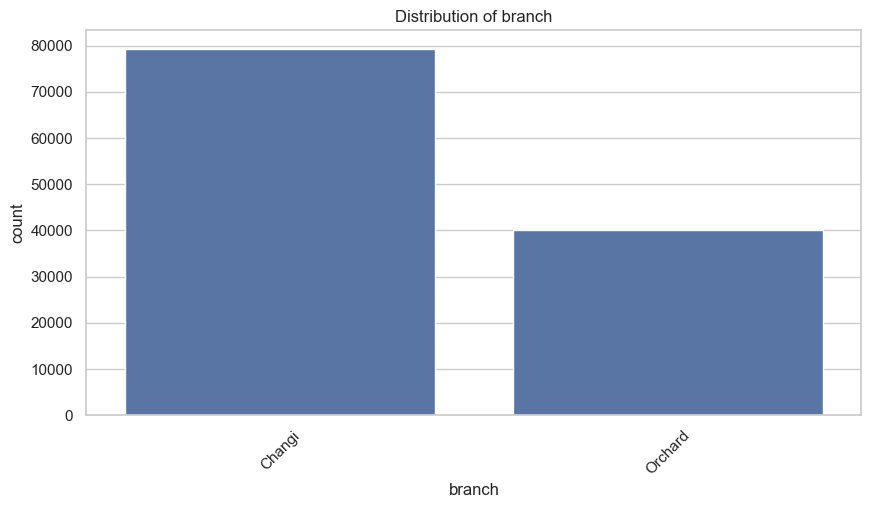

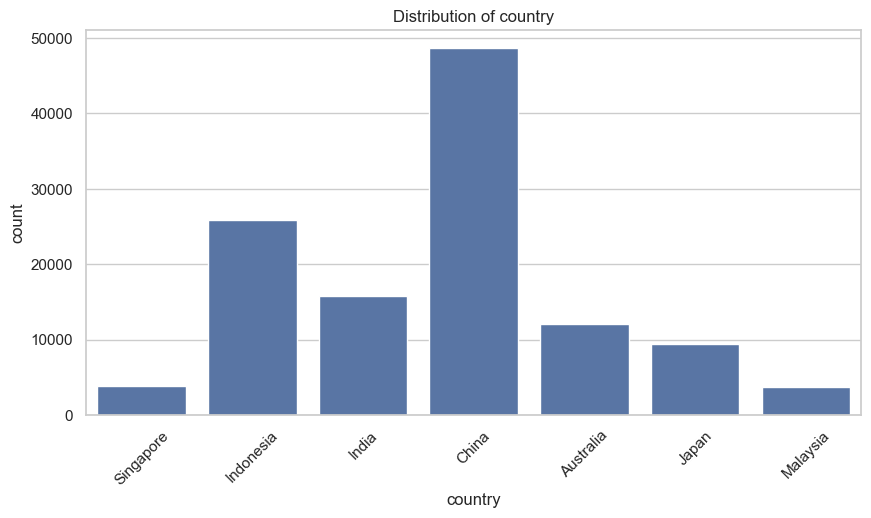

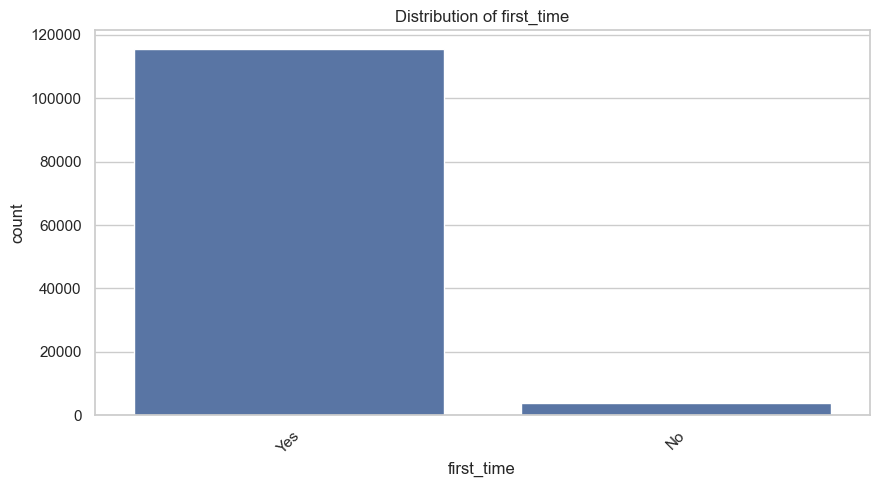

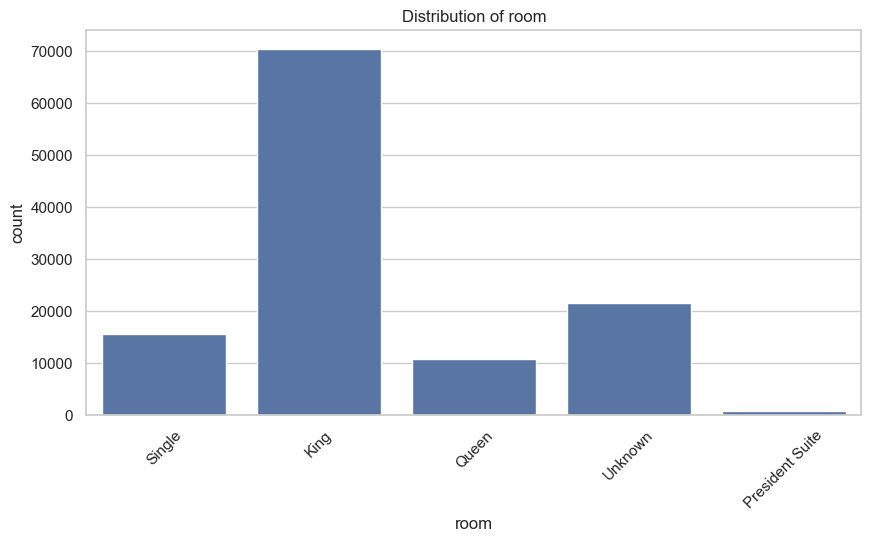

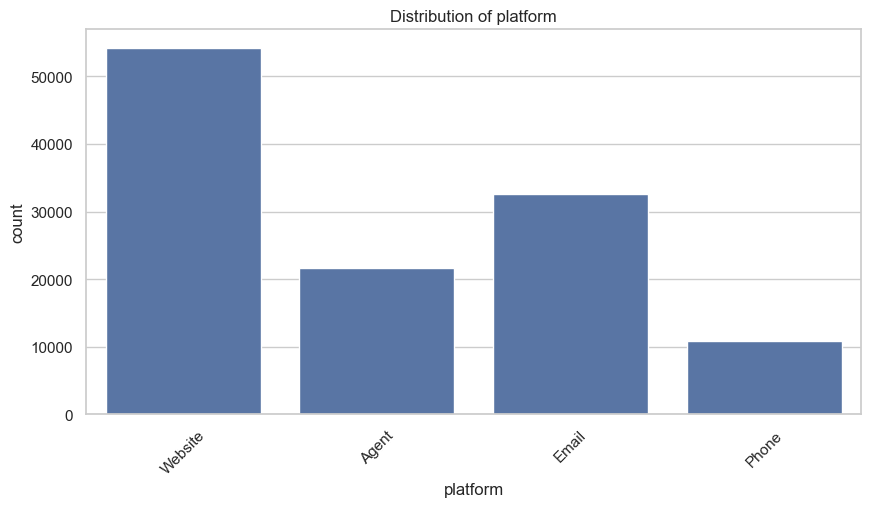

In [16]:
cat_col_list = ["branch", "country", "first_time", "room", "platform"]

for col in cat_col_list:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, data=cleaned_noshow_data_df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

Analyze distribution and relationship of numerical variables

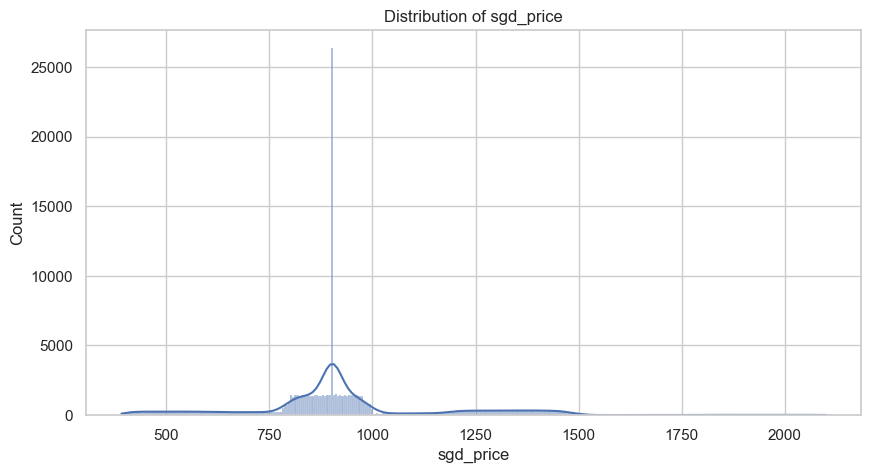

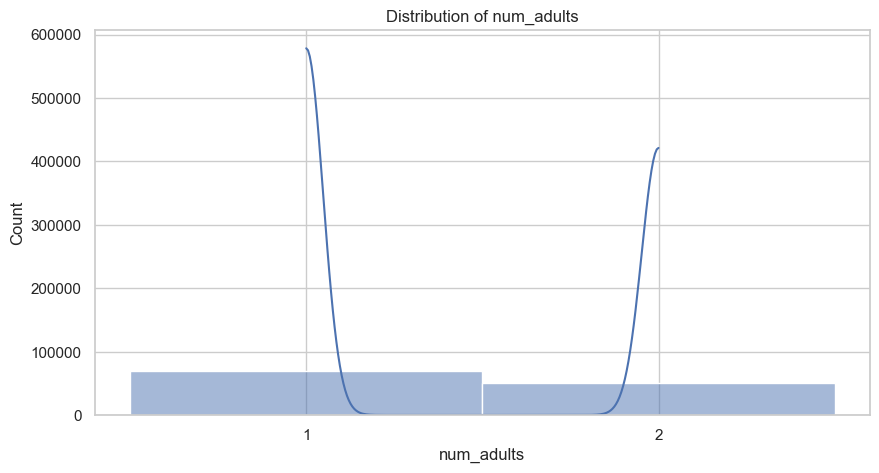

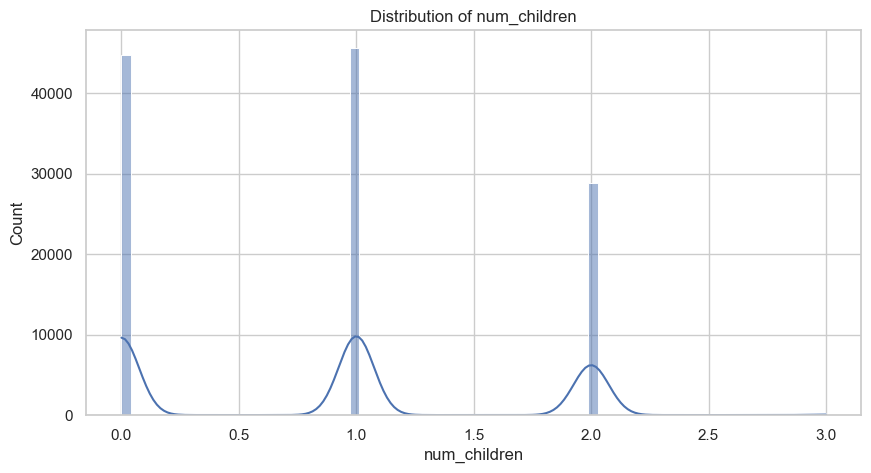

In [17]:
num_col_list = ["sgd_price", "num_adults", "num_children"]

for col in num_col_list:
    plt.figure(figsize=(10,5))
    sns.histplot(cleaned_noshow_data_df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

Perform label categorization to make all columns have categorical values 

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

standard_list = ["sgd_price", "stayed_num_days"]
one_hot_list = ["branch", "booking_month", "country", "first_time", "room", "platform", "trip_season", "num_adults", "num_children"]

lab_enc = LabelEncoder()
cleaned_noshow_data_df["no_show"] = lab_enc.fit_transform(cleaned_noshow_data_df["no_show"])

# Standardize data-set
scaler = StandardScaler()
cleaned_noshow_data_df[standard_list] = scaler.fit_transform(cleaned_noshow_data_df[standard_list])

# Perform one-hot encoding on categorical variables
encoded_noshow_data_df = pd.get_dummies(cleaned_noshow_data_df, columns = one_hot_list, drop_first=True)
bool_col = encoded_noshow_data_df.select_dtypes(include=["bool"]).columns
encoded_noshow_data_df[bool_col] = encoded_noshow_data_df[bool_col].astype(int)
encoded_noshow_data_df

,no_show,sgd_price,stayed_num_days,branch_Orchard,booking_month_August,booking_month_December,booking_month_February,booking_month_January,booking_month_July,booking_month_June,booking_month_March,booking_month_May,booking_month_November,booking_month_October,booking_month_September,country_China,country_India,country_Indonesia,country_Japan,country_Malaysia,country_Singapore,first_time_Yes,room_President Suite,room_Queen,room_Single,room_Unknown,platform_Email,platform_Phone,platform_Website,trip_season_spring,trip_season_summer,trip_season_winter,num_adults_2,num_children_1.0,num_children_2.0,num_children_3.0
0,0,-1.867523,-0.051748,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0
1,0,1.789864,-0.511572,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,0,-0.122568,0.867899,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,1,-1.130028,-0.051748,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0,-0.168823,0.867899,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119386,0,-0.472559,-0.051748,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0
119387,0,1.977833,0.867899,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0
119388,1,-0.305302,-0.511572,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0
119389,0,-0.191178,-0.051748,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0


It can now be used to generate summary statistics to check on mean, median, 25%, etc

In [19]:
# Get summary statistics from 'noshow' DataFrame
summary_stats = encoded_noshow_data_df.describe()

# Display summary statistics
summary_stats

,no_show,sgd_price,stayed_num_days,branch_Orchard,booking_month_August,booking_month_December,booking_month_February,booking_month_January,booking_month_July,booking_month_June,booking_month_March,booking_month_May,booking_month_November,booking_month_October,booking_month_September,country_China,country_India,country_Indonesia,country_Japan,country_Malaysia,country_Singapore,first_time_Yes,room_President Suite,room_Queen,room_Single,room_Unknown,platform_Email,platform_Phone,platform_Website,trip_season_spring,trip_season_summer,trip_season_winter,num_adults_2,num_children_1.0,num_children_2.0,num_children_3.0
count,119390.000000,1.193900e+05,1.193900e+05,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,-6.197832e-16,2.582926e-17,0.335539,0.084881,0.080082,0.080308,0.085552,0.083700,0.086473,0.081699,0.080308,0.086104,0.084329,0.086398,0.406986,0.132256,0.216199,0.078658,0.031544,0.032767,0.968088,0.006374,0.090661,0.131477,0.181020,0.273122,0.090569,0.454259,0.273675,0.313904,0.174026,0.421400,0.381573,0.241712,0.002077
std,0.482918,1.000004e+00,1.000004e+00,0.472181,0.278706,0.271421,0.271771,0.279702,0.276939,0.281062,0.273906,0.271771,0.280519,0.277881,0.280951,0.491274,0.338770,0.411653,0.269206,0.174783,0.178026,0.175767,0.079583,0.287127,0.337922,0.385037,0.445565,0.286996,0.497905,0.445846,0.464080,0.379134,0.493786,0.485775,0.428122,0.045529
min,0.000000,-2.300860e+00,-5.115716e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-3.964541e-01,-5.115716e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.225677e-01,-5.174797e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.477767e-01,-5.174797e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,4.980617e+00,2.845732e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Step 3: Analyze the patterns and distributions in 'noshow' DataFrame

Plot heatmap for dimension reduction visualization

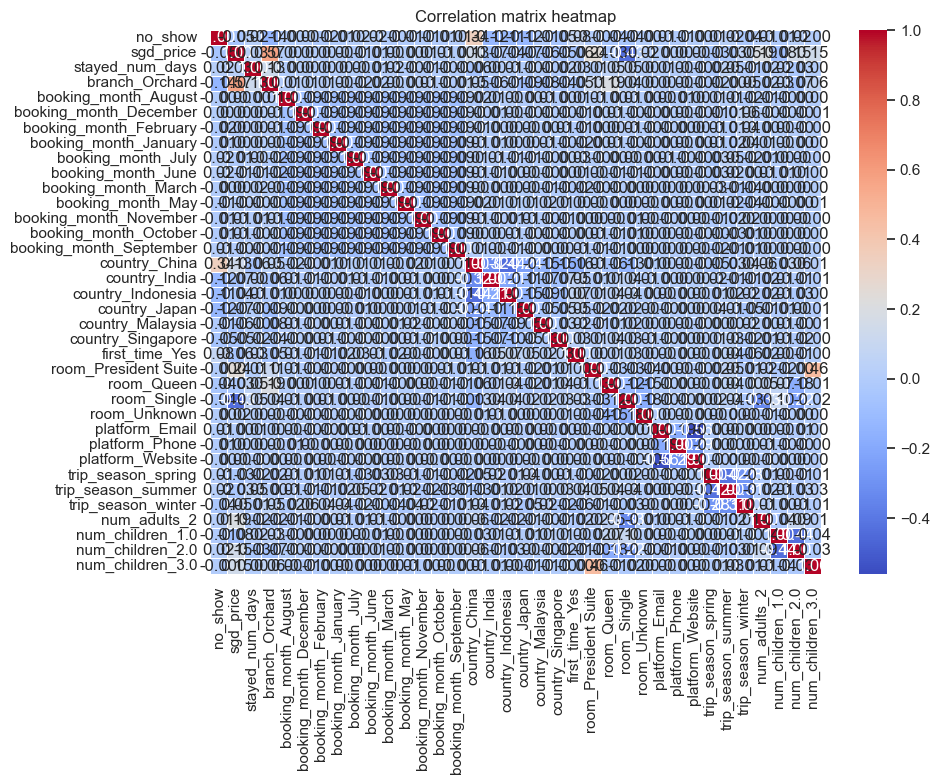

Correlation with 'no_show': 
no_show                    1.000000
country_China              0.336122
branch_Orchard             0.136531
country_India              0.121232
country_Japan              0.120712
country_Indonesia          0.112379
first_time_Yes             0.084793
sgd_price                  0.052989
country_Singapore          0.049694
room_Single                0.041545
trip_season_winter         0.037611
room_Queen                 0.037174
booking_month_June         0.024735
trip_season_summer         0.023692
num_children_2.0           0.022709
stayed_num_days            0.019748
booking_month_February     0.019309
booking_month_July         0.015935
num_adults_2               0.014506
booking_month_January      0.012615
booking_month_May          0.010438
trip_season_spring         0.009610
num_children_1.0           0.008951
booking_month_November     0.008092
booking_month_September    0.007912
country_Malaysia           0.006151
booking_month_October      0.005577

In [20]:
# Calculate correlation matrix
corr_matrix = encoded_noshow_data_df.corr()

# Create heatmap of correlation matrix
plt.figure(figsize = (10, 8)) # Adjust size as needed
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths=0.5)

# Show plot
plt.title("Correlation matrix heatmap")
plt.tight_layout()
plt.show()

no_show_corr = corr_matrix["no_show"]

# Sort correlations by absolute value (if strong correlations should be prioritized)
sorted_corr = no_show_corr.abs().sort_values(ascending=False)

# Print numerical correlation values
print("Correlation with 'no_show': ")
print(sorted_corr)

Drop features with correlation value < 0.05

In [21]:
drop_cols = sorted_corr[sorted_corr < 0.05].index

final_noshow_data_df = encoded_noshow_data_df.drop(columns = drop_cols, axis = 1)
final_noshow_data_df

,no_show,sgd_price,branch_Orchard,country_China,country_India,country_Indonesia,country_Japan,first_time_Yes
0,0,-1.867523,0,0,0,0,0,1
1,0,1.789864,1,0,0,1,0,1
2,0,-0.122568,0,0,1,0,0,1
3,1,-1.130028,1,1,0,0,0,1
4,0,-0.168823,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...
119386,0,-0.472559,0,1,0,0,0,1
119387,0,1.977833,1,1,0,0,0,1
119388,1,-0.305302,0,0,0,1,0,1
119389,0,-0.191178,0,1,0,0,0,1


Check correlation matrix again

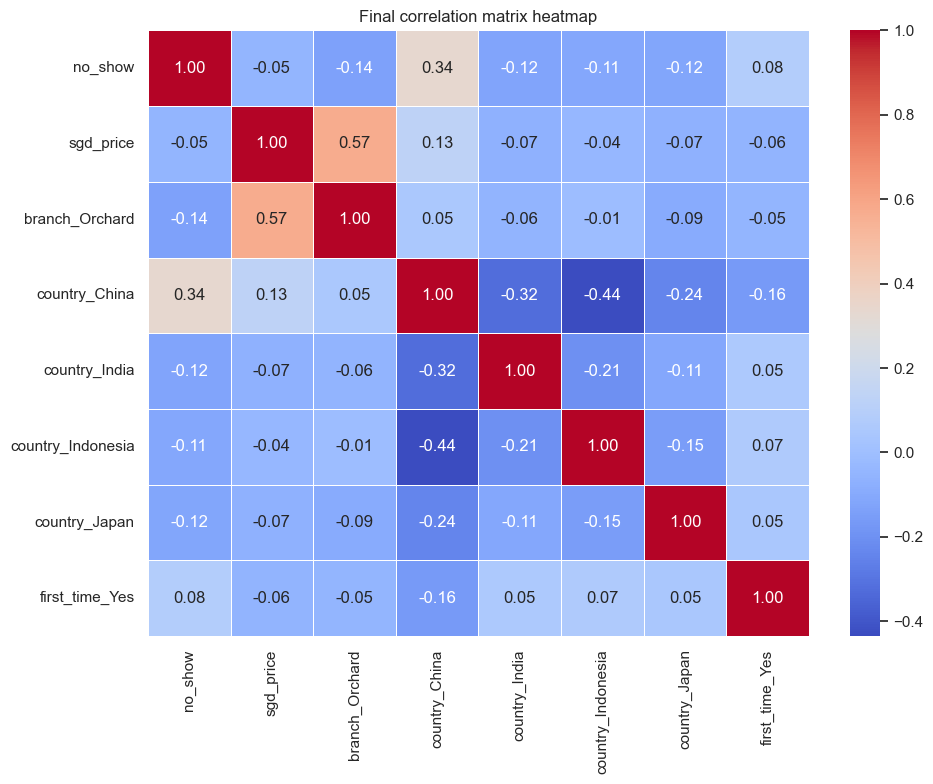

Correlation with 'no_show': 
no_show              1.000000
country_China        0.336122
branch_Orchard       0.136531
country_India        0.121232
country_Japan        0.120712
country_Indonesia    0.112379
first_time_Yes       0.084793
sgd_price            0.052989
Name: no_show, dtype: float64


In [22]:
# Calculate correlation matrix
final_corr_matrix = final_noshow_data_df.corr()

# Create heatmap of correlation matrix
plt.figure(figsize = (10, 8)) # Adjust size as needed
sns.heatmap(final_corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f", linewidths=0.5)

# Show plot
plt.title("Final correlation matrix heatmap")
plt.tight_layout()
plt.show()

final_no_show_corr = final_corr_matrix["no_show"]

# Sort correlations by absolute value (if strong correlations should be prioritized)
final_sorted_corr = final_no_show_corr.abs().sort_values(ascending=False)

# Print numerical correlation values
print("Correlation with 'no_show': ")
print(final_sorted_corr)

Testing ML for chosen features in final_noshow_data_df

In [23]:
X = final_noshow_data_df.drop(["no_show"], axis = 1)
Y = final_noshow_data_df["no_show"]

from sklearn.model_selection import train_test_split

# Split data into test and train (20/80 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

Check original class distribution in training set

In [24]:
print("Original class distribution in training set:")
print(pd.Series(Y_train).value_counts())

Original class distribution in training set:
no_show
0    60055
1    35457
Name: count, dtype: int64


Apply SMOTE (Syntheetic Minority Over-sampling Technique) to balance dataset

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="auto", random_state=42)
resampled_X_train, resampled_Y_train = smote.fit_resample(X_train, Y_train)

Check new class distribution after SMOTE

In [26]:
print("Class distribution after SMOTE:")
print(pd.Series(resampled_Y_train).value_counts())

Class distribution after SMOTE:
no_show
0    60055
1    60055
Name: count, dtype: int64


In [27]:
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()

resampled_Y_train = lab_enc.fit_transform(resampled_Y_train)
Y_test = lab_enc.fit_transform(Y_test)

Start with Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

log_model = LogisticRegression()
log_model.fit(resampled_X_train, resampled_Y_train)
log_Y_predict = log_model.predict(X_test)

log_confuse_matrix = confusion_matrix(Y_test, log_Y_predict)
log_class_rpt = classification_report(Y_test, log_Y_predict)

print("Pre-tuned Logistic Regression - ")
print(f"Confusion Matrix: \n{log_confuse_matrix}")
print(f"Classification Report: \n{log_class_rpt}")

Pre-tuned Logistic Regression - 
Confusion Matrix: 
[[11370  3741]
 [ 3378  5389]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     15111
           1       0.59      0.61      0.60      8767

    accuracy                           0.70     23878
   macro avg       0.68      0.68      0.68     23878
weighted avg       0.70      0.70      0.70     23878



Tune Logistic Regression for better results

In [29]:
def tune_n_eval_log_regression(X_train, Y_train, X_test, Y_test, search_method = "grid", param_grid = None, param_dist = None, random_iter = 50, cv = 5, num_jobs = 4):
    """
    Automates the tuning and evaluation of a Random Forest Regressor model.

    Parameters:
        X: Features (DataFrame or array).
        y: Target variable (Series or array).
        search_method: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV.
        param_grid: Dictionary of hyperparameter ranges for GridSearchCV.
        param_dist: Dictionary of hyperparameter distributions for RandomizedSearchCV.
        random_iter: Number of iterations for RandomizedSearchCV.
        cv: Number of cross-validation folds.

    Returns:
        best_model: The tuned Random Forest Regressor model.
        best_params: The best hyperparameters found.
    """
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    import random

    # Initialize parameters
    if param_grid is None:
        param_grid = {
            "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky"], # sag omitted due to non-convergence at current max_iter values
            "max_iter": [50, 75, 100, 125],
            "C": [0.1, 1, 5, 10],
            "class_weight": ["balanced", {0: 1, 1: 1.7}, {0: 1, 1: 5}]
        }
    if param_dist is None:
        from scipy.stats import randint
        param_dist = {
            "solver": ["lbfgs", "liblinear", "sag", "newton-cg", "newton-cholesky"],
            "max_iter": randint(50, 200),
            "C": [round(random.uniform(0, 20), 1) for _ in range(5)],
            "class_weight": ["balanced", {0: 1, 1: 1.7}, {0: 1, 1: 5}]
        }

    if search_method == "grid":
        search = GridSearchCV(
            LogisticRegression(random_state = 42),
            param_grid = param_grid,
            cv = cv,
            scoring = "neg_mean_squared_error",
            n_jobs = num_jobs
        )
    elif search_method == "random":
        search = RandomizedSearchCV(
            LogisticRegression(random_state = 42),
            param_distributions = param_dist,
            n_iter = random_iter,
            cv = cv,
            scoring = "neg_mean_squared_error",
            random_state = 42,
            n_jobs = num_jobs
        )
    else:
        raise ValueError("search_method must be either 'grid' or ' random'")
    
    # Fit the search
    print(f"Running {search_method.capitalize()} Search...")
    search.fit(X_train, Y_train)

    # Best model and parameters
    best_model = search.best_estimator_
    best_params = search.best_params_
    print(f"\nBest Parameters: {best_params}")

    # Test set evaluation
    tuned_log_Y_predict = best_model.predict(X_test)
    tuned_log_confuse_matrix = confusion_matrix(Y_test, tuned_log_Y_predict)
    tuned_log_class_rpt = classification_report(Y_test, tuned_log_Y_predict)
    print("Tuned Logistic Regression -")
    print(f"Tuned Set Confusion Matrix: \n{tuned_log_confuse_matrix}")
    print(f"Tuned Set Classification Report: \n{tuned_log_class_rpt}")

    # Plot Confusion Matrix of actual vs predicted
    conf_matrix = confusion_matrix(Y_test, log_Y_predict)

    ConfusionMatrixDisplay(conf_matrix, display_labels=["No_Show", "Show"]).plot(cmap="Blues")
    plt.show()

    return best_model, best_params

Running Grid Search...

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 50, 'solver': 'lbfgs'}
Tuned Logistic Regression -
Tuned Set Confusion Matrix: 
[[11370  3741]
 [ 3378  5389]]
Tuned Set Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     15111
           1       0.59      0.61      0.60      8767

    accuracy                           0.70     23878
   macro avg       0.68      0.68      0.68     23878
weighted avg       0.70      0.70      0.70     23878



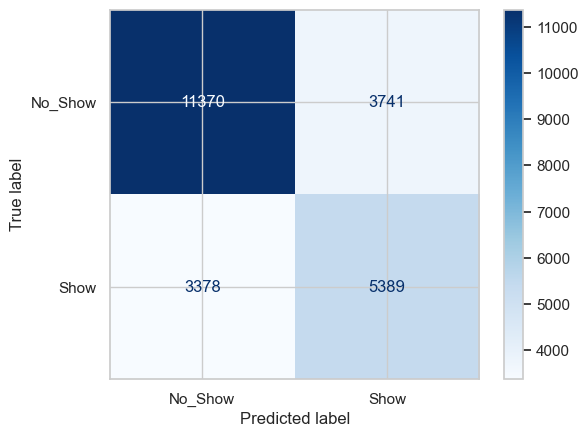

In [30]:
# Using Grid Search
grid_log_best_model, grid_log_best_param = tune_n_eval_log_regression(
    resampled_X_train,
    resampled_Y_train,
    X_test,
    Y_test,
    search_method = "grid",
    num_jobs = -1
)

Running Random Search...

Best Parameters: {'C': 19.4, 'class_weight': 'balanced', 'max_iter': 64, 'solver': 'sag'}
Tuned Logistic Regression -
Tuned Set Confusion Matrix: 
[[11370  3741]
 [ 3378  5389]]
Tuned Set Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     15111
           1       0.59      0.61      0.60      8767

    accuracy                           0.70     23878
   macro avg       0.68      0.68      0.68     23878
weighted avg       0.70      0.70      0.70     23878



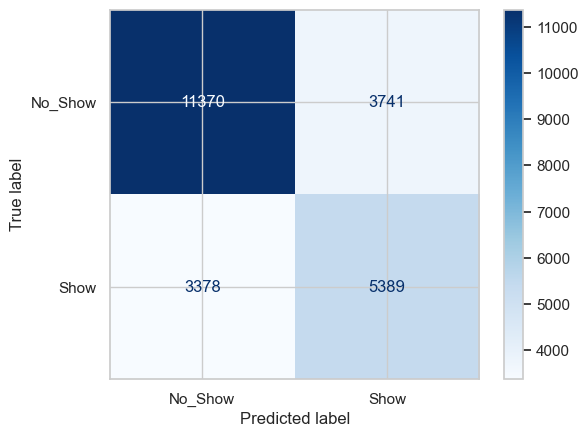

In [31]:
# Using Random Search
rand_log_best_model, rand_log_best_param = tune_n_eval_log_regression(
    resampled_X_train,
    resampled_Y_train,
    X_test,
    Y_test,
    search_method = "random",
    num_jobs = -1
)

Next, try with Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rand_for_model = RandomForestClassifier()
rand_for_model.fit(resampled_X_train, resampled_Y_train)
rand_for_Y_predict = rand_for_model.predict(X_test)

rand_for_confuse_matrix = confusion_matrix(Y_test, rand_for_Y_predict)
rand_for_class_rpt = classification_report(Y_test, rand_for_Y_predict)

print("Pre-tuning Random Forest Classifier - ")
print(f"Confusion Matrix: \n{rand_for_confuse_matrix}")
print(f"Classification Report: \n{rand_for_class_rpt}")

Pre-tuning Random Forest Classifier - 
Confusion Matrix: 
[[9873 5238]
 [3901 4866]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.65      0.68     15111
           1       0.48      0.56      0.52      8767

    accuracy                           0.62     23878
   macro avg       0.60      0.60      0.60     23878
weighted avg       0.63      0.62      0.62     23878



Tune Random Forest for better results

In [40]:
def tune_n_eval_forest_classifier(X_train, Y_train, X_test, Y_test, search_method = "grid", param_grid = None, param_dist = None, random_iter = 50, cv = 5, num_jobs = 4):
    """
    Automates the tuning and evaluation of a Random Forest Regressor model.

    Parameters:
        X: Features (DataFrame or array).
        y: Target variable (Series or array).
        search_method: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV.
        param_grid: Dictionary of hyperparameter ranges for GridSearchCV.
        param_dist: Dictionary of hyperparameter distributions for RandomizedSearchCV.
        random_iter: Number of iterations for RandomizedSearchCV.
        cv: Number of cross-validation folds.

    Returns:
        best_model: The tuned Random Forest Regressor model.
        best_params: The best hyperparameters found.
    """
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Initialize parameters
    if param_grid is None:
        param_grid = {
            "n_estimators": [50, 100, 150, 200],
            "max_depth": [None, 5, 10],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
            "class_weight": ["balanced", {0: 1, 1: 1.7}, {0: 1, 1: 5}]
        }
    if param_dist is None:
        from scipy.stats import randint
        param_dist = {
            "n_estimators": randint(100, 500),
            "max_depth": [None, 5, 10, 15],
            "max_features": ["sqrt", "log2", None],
            "min_samples_split": randint(2, 20),
            "min_samples_leaf": randint(1, 20)
        }

    if search_method == "grid":
        search = GridSearchCV(
            RandomForestClassifier(random_state = 42),
            param_grid = param_grid,
            cv = cv,
            scoring = "neg_mean_squared_error",
            n_jobs = num_jobs,
            verbose = 3
        )
    elif search_method == "random":
        search = RandomizedSearchCV(
            RandomForestClassifier(random_state = 42),
            param_distributions = param_dist,
            n_iter = random_iter,
            cv = cv,
            scoring = "neg_mean_squared_error",
            random_state = 42,
            n_jobs = num_jobs,
            verbose = 3
        )
    else:
        raise ValueError("search_method must be either 'grid' or ' random'")
    
    # Fit the search
    print(f"Running {search_method.capitalize()} Search...")
    search.fit(X_train, Y_train)

    # Best model and parameters
    best_model = search.best_estimator_
    best_params = search.best_params_
    print(f"\nBest Parameters: {best_params}")

    # Test set evaluation
    tuned_rand_for_Y_predict = best_model.predict(X_test)
    tuned_rand_for_confuse_matrix = confusion_matrix(Y_test, tuned_rand_for_Y_predict)
    tuned_rand_for_class_rpt = classification_report(Y_test, tuned_rand_for_Y_predict)
    print("Tuned Random Forest Classification -")
    print(f"Tuned Set Confusion Matrix: \n{tuned_rand_for_confuse_matrix}")
    print(f"Tuned Set Classification Report: \n{tuned_rand_for_class_rpt}")

    # Plot Confusion Matrix of actual vs predicted
    conf_matrix = confusion_matrix(Y_test, log_Y_predict)

    ConfusionMatrixDisplay(conf_matrix, display_labels=["No_Show", "Show"]).plot(cmap="Blues")
    plt.show()

    return best_model, best_params

Call tuning and evaluation function

In [41]:
# Temp removed due to long run time
## Using Grid Search
#grid_rand_for_best_model, grid_rand_for_best_param = tune_n_eval_forest_classifier(
#    resampled_X_train,
#    resampled_Y_train,
#    X_test,
#    Y_test,
#    search_method = "grid",
#    num_jobs = -1
#)

Running Random Search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 406}
Tuned Random Forest Classification -
Tuned Set Confusion Matrix: 
[[10861  4250]
 [ 3159  5608]]
Tuned Set Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.72      0.75     15111
           1       0.57      0.64      0.60      8767

    accuracy                           0.69     23878
   macro avg       0.67      0.68      0.67     23878
weighted avg       0.70      0.69      0.69     23878



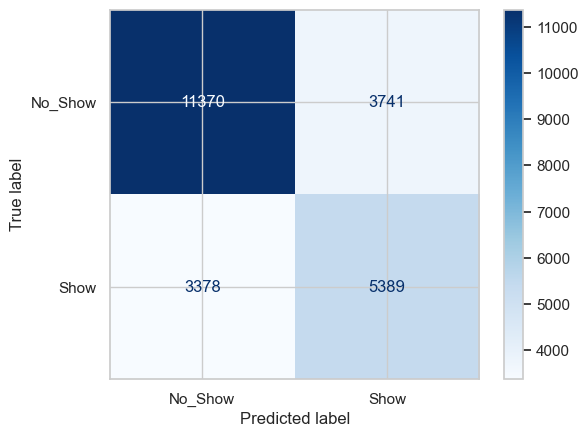

In [43]:
# Using Random Search
rand_rand_for_best_model, rand_rand_for_best_param = tune_n_eval_forest_classifier(
    resampled_X_train,
    resampled_Y_train,
    X_test,
    Y_test,
    search_method = "random",
    num_jobs = 4
)

Use XGBoost for variation

In [44]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(resampled_X_train, resampled_Y_train)
xgb_Y_predict = xgb_model.predict(X_test)

xgb_confuse_matrix = confusion_matrix(Y_test, xgb_Y_predict)
xgb_class_rpt = classification_report(Y_test, xgb_Y_predict)

print("XGBoost - ")
print(f"Confusion Matrix: \n{xgb_confuse_matrix}")
print(f"Classification Report: \n{xgb_class_rpt}")

XGBoost - 
Confusion Matrix: 
[[10861  4250]
 [ 3110  5657]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.72      0.75     15111
           1       0.57      0.65      0.61      8767

    accuracy                           0.69     23878
   macro avg       0.67      0.68      0.68     23878
weighted avg       0.70      0.69      0.70     23878



Plot XGBoost's Confusion Matrix

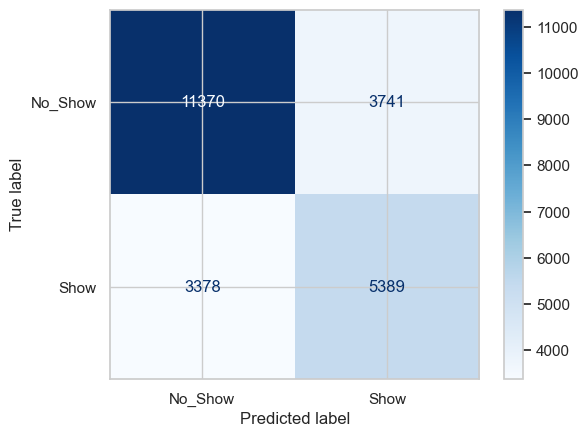

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

xgb_conf_matrix = confusion_matrix(Y_test, log_Y_predict)

ConfusionMatrixDisplay(xgb_conf_matrix, display_labels=["No_Show", "Show"]).plot(cmap="Blues")
plt.show()

Check variance and range of target variable - no_show <br>
(Skipped for classifier)

In [46]:
## Calculate variance of target variable
#variance_no_show = Y_test.var() # Variance of actual target values
#print(f"Variance of 'no_show': {variance_no_show:.3f}")
#
## Calculate range of target variable
#range_no_show = Y_test.max() - Y_test.min()
#print(f"Range of 'no_show': {range_no_show:.3f}")

Perform ML with PCA (95% variance) features <br>

In [47]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components = 0.95) # Keep 95% of variance
X_pca = pca.fit_transform(X)

print("Explained variance ratio: ", pca.explained_variance_ratio_)
print("Cumulative explained variance: ", np.cumsum(pca.explained_variance_ratio_))

pca_X_train, pca_X_test, pca_Y_train, pca_Y_test = train_test_split(X_pca, Y, test_size = 0.2, random_state = 42)
resampled_pca_X_train, resampled_pca_Y_train = smote.fit_resample(pca_X_train, pca_Y_train)

pca_model = RandomForestClassifier()
pca_model.fit(resampled_pca_X_train, resampled_pca_Y_train)

pca_Y_predict = pca_model.predict(pca_X_test)
pca_confuse_matrix = confusion_matrix(Y_test, pca_Y_predict)
pca_class_rpt = classification_report(Y_test, pca_Y_predict)

print("PCA Random Forest Classifier - ")
print(f"Confusion Matrix: \n{pca_confuse_matrix}")
print(f"Classification Report: \n{pca_class_rpt}")

Explained variance ratio:  [0.58898644 0.1628769  0.08885636 0.07524124 0.05108508]
Cumulative explained variance:  [0.58898644 0.75186333 0.84071969 0.91596093 0.96704601]
PCA Random Forest Classifier - 
Confusion Matrix: 
[[9880 5231]
 [3895 4872]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.72      0.65      0.68     15111
           1       0.48      0.56      0.52      8767

    accuracy                           0.62     23878
   macro avg       0.60      0.60      0.60     23878
weighted avg       0.63      0.62      0.62     23878



Perform cross-validation with PCA feature <br>
(Skipped for classifier)

In [48]:
#from sklearn.model_selection import cross_val_score
#x_valid_model = RandomForestClassifier(random_state = 42)
#
## Perform 5-fold cross validation
#scores = cross_val_score(x_valid_model, X, Y, cv=5, scoring="neg_mean_squared_error")
#
#print(f"Cross-validation Mean Mean Squared Error: {-scores.mean():.4f}")
#print(f"Cross-validation STD Mean Squared Error: {-scores.std():.4f}")